In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_score



from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px

import warnings

import seaborn as sns




In [141]:


# for col in data_t.columns:
#    if not (data_t[col].apply(lambda x: isinstance(x, str))).all():
#        continue
   
#    if (data_t[col].apply(lambda x: isinstance(x, str)).all() & data_t[col].str.contains(',')).any():
#         try:
#             data_t[col] = data_t[col].replace('[\$,]', '', regex=True).astype(float)
#         except AttributeError as err:
#             print([col])
#             break   
# data_t = data_t.iloc[1:, :]

In [142]:
def processData(flag=False):
    data_t = pd.read_csv('prison_2010_excel.txt', delimiter='\t', skiprows=2)
    data_t = data_t.drop((53))
    data_t = data_t.drop((0))

    df = data_t.iloc[:, 2:]
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)

    # Create a boolean mask of NaN values
    nan_mask = df.isnull()

    # Check for any NaN values in each row
    nan_in_row = nan_mask.any(axis=1)

    # Check for any NaN values in each column
    nan_in_col = nan_mask.any(axis=0)
    rows_with_nans = df[nan_in_row]
    cols_with_nans = df.loc[:, nan_in_col]
    if flag:
        print("Features Containing NaN:", cols_with_nans)
    
    # df = df.drop(columns=cols_with_nans).filter(regex='^(?!.*(Population)).*')
    df = df.drop(columns=cols_with_nans)


    # Add Percentages to DataFrame
    percent_men = getPercentage(df)[0]
    percent_women= getPercentage(df)[1]
    percent_both= getPercentage(df)[2]
    
    
    # Standardize the numerical features
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)
    df[df_std.columns] = df_std
    df = pd.concat([df, percent_men, percent_women, percent_both], axis=1)


    
    return df
def abbreviate_column_name(col_name):
    abbreviation = ''.join([word[0] for word in col_name.split() if word[0].isalpha()])
    return abbreviation.upper()


def getX(df):
       X = df.iloc[:, 2:]
       return X
def getY(df):
    y = df.iloc[:, 1] # select only the first column
    return y


def runKmeans(data, X, n):
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=10)
    kmeans.fit(X)
    cluster_data = data.copy() 
    cluster_data['Cluster'] = kmeans.labels_
    return cluster_data, kmeans

def runGaussian(data, X, n):
    X = X.filter(regex='^(?!.*(Total)).*')
    cluster_data = data.copy()

    # Fit a Gaussian Mixture Model with 4 clusters
    gmm = GaussianMixture(n_components=n)
    gmm.fit(X)

    # Get cluster predictions for each row
    clusters = gmm.predict(X)

    # Get probability scores for each row
    probs = gmm.predict_proba(X)

    # Add cluster and probability columns to original dataframe
    cluster_data['Cluster'] = clusters
    cluster_data['Probability'] = probs.max(axis=1)

    # Print the
    return cluster_data


# def createBarChart(cluster_data, x_axis="Geography", y_axis="empty"): 
#     fig = px.bar(cluster_data, x=x_axis, y=y_axis, color='Cluster')
#     fig.show()
def createBarChart(cluster_data, x_axis="Geography", y_axis="empty"): 
    return px.bar(cluster_data, x=x_axis, y=y_axis, color='Cluster')
    

def stateClusterGraph(cluster_data):
    state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
    }
    cluster_data['State Abbreviation'] = cluster_data['Geography'].map(state_abbreviations)


    # Create a choropleth map
    fig = px.choropleth(cluster_data, locations='State Abbreviation', locationmode='USA-states', color='Cluster', scope='usa', title='Clusters by State')

    # fig.show()
    return fig


def elbow_method(df, n):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df.iloc[:,1:6]

    # Perform K-means clustering for different values of K
    inertias = []
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, init = 'k-means++' , random_state=42, n_init=10).fit(X)
        inertia = kmeans.inertia_
        inertias.append(inertia)

    # Plot the elbow curve to choose the optimal value of K
    plt.plot(range(1, n), inertias, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal K')
    plt.show()

    # create dataframe for elbow plot data
    elbow_data = pd.DataFrame({
        'K': range(1, n),
        'Inertia': inertias
    })
    elbow_data = elbow_data.set_index('K')

    # print(elbow_data)

    # Calculate the slope and second derivative of the inertia curve
    slopes = [inertias[i+1] - inertias[i] for i in range(len(inertias)-1)]
    second_derivatives = [slopes[i+1] - slopes[i] for i in range(len(slopes)-1)]

    # Find the index of the maximum second derivative
    max_index = second_derivatives.index(max(second_derivatives))

    # The optimal value of K is one more than the index of the maximum second derivative
    best_k = max_index + 2
    # print(best_k)

    # return df, elbow_data, inertias, best_k


def correlationMap(df):
    # Select only the numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64'])
    
    # Calculate the correlation matrix
    corr_matrix = numeric_columns.corr()
    
    # Set the upper triangle to NaN
    corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool))
    np.fill_diagonal(corr_matrix.values, np.nan)
    # Rename columns and index using abbreviated column names
    corr_matrix.columns = [abbreviate_column_name(col) for col in corr_matrix.columns]
    corr_matrix.index = [abbreviate_column_name(col) for col in corr_matrix.index]
    

    
    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title('Correlation of Numeric Features')
    plt.show()

def visualizing_results_2d(df,n,col1, col2, col3):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df[[col1, col2, col3]]
    # Create a KMeans instance with k = n
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10)
    # Fit the model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    df['Cluster'] = kmeans.labels_
    # Get the cluster centroids
    centroids = kmeans.cluster_centers_
    # Create an empty figure
    # Abbreviate column names


    
    col1_abbrev = abbreviate_column_name(col1)
    col2_abbrev = abbreviate_column_name(col2)
    col3_abbrev = abbreviate_column_name(col3)
    
    # Create an empty figure
    fig = make_subplots(rows=3, cols=1, subplot_titles=(
        f"{col1_abbrev} by {col2_abbrev}", f"{col1_abbrev} by {col3_abbrev}", f"{col2_abbrev} by {col3_abbrev}"))
    # Add a scatter plot of the data points to the first subplot
    fig.add_trace(
        go.Scatter(
            x=df[col1],
            y=df[col2],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=1,
        col=1
    )
    # Add a scatter plot of the centroids to the first subplot
    fig.add_trace(
        go.Scatter(
            x=centroids[:, 0],
            y=centroids[:, 1],
            mode='markers',
            marker=dict(
                size=10,
                color='red',
                symbol='star',
                line=dict(
                    width=1,
                    color='black'
                )
            ),
            name='Centroids'
        ),
        row=1,
        col=1
    )
    # Add a scatter plot of word_id by counts to the second subplot
    fig.add_trace(
        go.Scatter(
            x=df[col1],
            y=df[col3],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=2,
        col=1
    )
    # Add a scatter plot of the centroids to the second subplot
    fig.add_trace(
        go.Scatter(
            x=centroids[:, 0],
            y=centroids[:, 2],
            mode='markers',
            marker=dict(
                size=10,
                color='red',
                symbol='star',
                line=dict(
                    width=1,
                    color='black'
                )
            ),
            name='Centroids'
        ),
        row=2,
        col=1
    )
     # Add a scatter plot of word_id by counts to the third subplot
    fig.add_trace(
        go.Scatter(
            x=df[col2],
            y=df[col3],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=3,
        col=1
    )
    # Add a scatter plot of the centroids to the third subplot
    fig.add_trace(
        go.Scatter(
            x=centroids[:, 1],
            y=centroids[:, 2],
            mode='markers',
            marker=dict(
                size=10,
                color='red',
                symbol='star',
                line=dict(
                    width=1,
                    color='black'
                )
            ),
            name='Centroids'
        ),
        row=3,
        col=1
    )
    # Update the layout of the figure
    fig.update_layout(
        height=900,
        width = 900,
        title=f'Clusters of {col1}, {col2} and {col3}'
    )
    # Show the figure
    fig.show()
def visualizing_results_3d(df, n, col1, col2, col3):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df[[col1, col2, col3]]
    # Create a KMeans instance with k = n
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10)
    # Fit the model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    df['Cluster'] = kmeans.labels_
    # Get the cluster centroids
    centroids = kmeans.cluster_centers_
    # Create an empty figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    # Add a 3D scatter plot of the data points
    fig.add_trace(
        go.Scatter3d(
            x=df[col1],
            y=df[col2],
            z=df[col3],
            mode='markers',
            marker=dict(color=df['Cluster']),
            showlegend=False
        )
    )
    # Add a scatter plot of the centroids
    fig.add_trace(
        go.Scatter3d(
            x=centroids[:, 0],
            y=centroids[:, 1],
            z=centroids[:, 2],
            mode='markers',
            marker=dict(size=10, color='red', symbol='circle', line=dict(width=1, color='black')),
            name='Centroids'
        )
    )
    # Update the layout of the figure
    fig.update_layout(
        height=800,
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis=dict(title=col1),
            yaxis=dict(title=col2),
            zaxis=dict(title=col3)
        ),
        title='Clusters'
    )
    # Show the figure
    fig.show()


def getCorrectionalPopulation(df):
    # Use filter and regex pattern to separate columns into their own dataframes

    # filter columns based on gender
    male_cols = df.filter(regex='(Total Men|: Men$)').columns.tolist()
    female_cols = df.filter(regex='(Total Women|: Women$)').columns.tolist()
    both_cols = df.filter(regex='(: In Correctional Facilities for Adults|: in Correctional Facilities for Adults$)').columns.tolist()


    df_male = df[male_cols]
    df_female = df[female_cols]
    df_both = df[both_cols]


    drop_men_women = [col for col in df_both.columns if 'Men' in col or 'Women' in col]
    df_both = df_both.drop(drop_men_women, axis=1)

    return df_male, df_female, df_both


def getPercentage(df):
    corr_men = getCorrectionalPopulation(df)[0]
    corr_women = getCorrectionalPopulation(df)[1]
    corr_both = getCorrectionalPopulation(df)[2]
    
    pop_men = getPopulation(df)[0]
    pop_men.columns = corr_men.columns
    pop_women = getPopulation(df)[1]
    pop_women.columns = corr_women.columns
    pop_both = getPopulation(df)[2]
    pop_both.columns = corr_both.columns

    

    percent_men = corr_men.div(pop_men, axis=0)*100
    percent_men.columns = ['Percent ' + col for col in percent_men.columns]

    percent_women = corr_women.div(pop_women, axis=0)*100
    percent_women.columns = ['Percent ' + col for col in percent_women.columns]

    percent_both = corr_both.div(pop_both, axis=0)*100
    percent_both.columns = ['Percent ' + col for col in percent_both.columns]
    return percent_men, percent_women, percent_both

def getPopulation(df):
    # Use filter and regex pattern to separate columns into their own dataframes

    # filter columns based on gender
    male_cols = df.filter(regex=': Male$').columns.tolist()
    female_cols = df.filter(regex=': Female$').columns.tolist() 
    both_cols = df.filter(regex='Total Population(?!.*(Male|Female)).*').columns.tolist()

    # create dataframes for male, female, and both
    df_male = df[male_cols]
    df_female = df[female_cols]
    df_both = df[both_cols]
    return df_male, df_female, df_both



## Raw Data
- After loading it data into data\_t we can then process and clean the data by calling processData() on it

In [143]:
df  = processData()
print(list(df.columns))

['Geography', 'Total : In Correctional Facilities for Adults', 'White alone : in Correctional Facilities for Adults', 'Black or African American alone : in Correctional Facilities for Adults', 'American Indian and Alaska Native alone : in Correctional Facilities for Adults', 'Asian alone : in Correctional Facilities for Adults', 'Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults', 'Some other race alone : in Correctional Facilities for Adults', 'Two or more races : in Correctional Facilities for Adults', 'Hispanic or Latino : in Correctional Facilities for Adults', 'White alone, not Hispanic or Latino : in Correctional Facilities for Adults', 'Total Population', 'Total Population: White alone', 'Total Population: Black or African American alone', 'Total Population: American Indian and Alaska Native alone', 'Total Population: Asian alone', 'Total Population: Native Hawaiian and other Pacific Islander alone', 'Total Population: Some other race alone

/var/folders/yn/4nkcf4bx0tl9zps6_x1krghm0000gn/T/ipykernel_84786/2548935044.py:7: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



/var/folders/yn/4nkcf4bx0tl9zps6_x1krghm0000gn/T/ipykernel_84786/2548935044.py:203: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



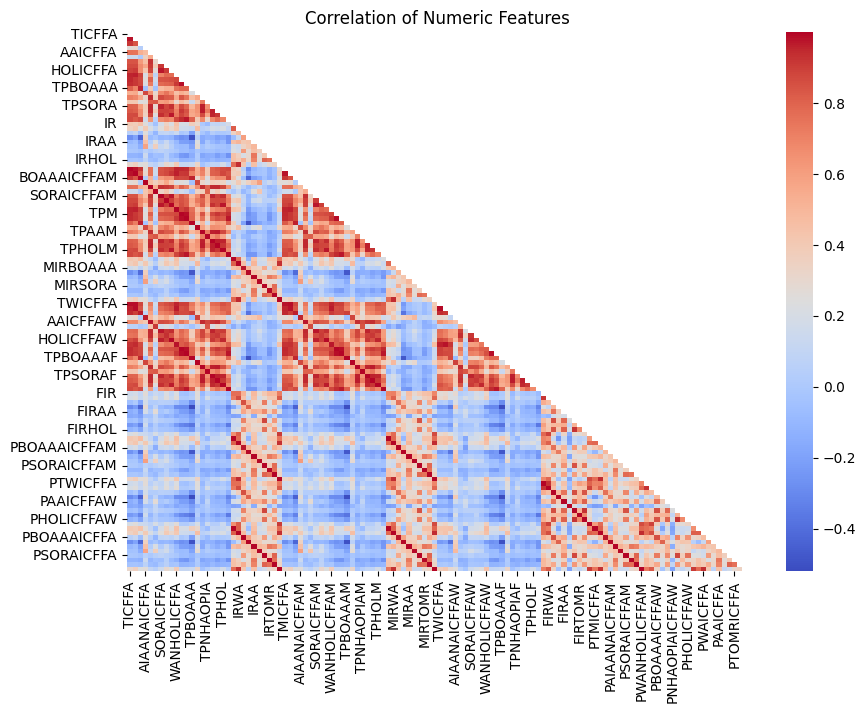

In [144]:
correlationMap(df)

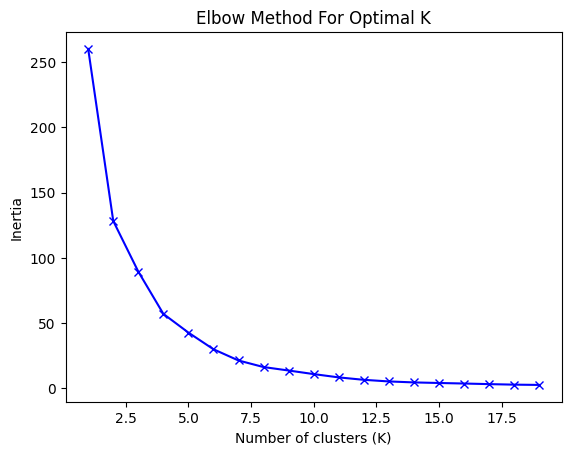

In [145]:
elbow_method(df, 20) ## Used to determine best k for K-means

In [146]:
n=4

In [147]:
createBarChart(runKmeans(df, getX(df), n)[0], x_axis="Geography", y_axis='Total : In Correctional Facilities for Adults')


In [148]:
visualizing_results_3d(df,n,'Incarceration rate', 'Female incarceration rate', 'Male incarceration rate')

In [149]:
visualizing_results_2d(df,n,'Incarceration rate', 'Female incarceration rate', 'Male incarceration rate')

In [150]:
visualizing_results_3d(df,n,'Total : In Correctional Facilities for Adults', 'Total Men : In Correctional Facilities for Adults', 'Total Women : In Correctional Facilities for Adults')

In [151]:
visualizing_results_2d(df,n,'Total : In Correctional Facilities for Adults', 'Total Men : In Correctional Facilities for Adults', 'Total Women : In Correctional Facilities for Adults')

In [152]:
visualizing_results_3d(df,n,'Percent Total : In Correctional Facilities for Adults', 'Percent Total Men : In Correctional Facilities for Adults', 'Percent Total Women : In Correctional Facilities for Adults')

In [153]:
visualizing_results_2d(df,n,'Percent Total : In Correctional Facilities for Adults', 'Percent Total Men : In Correctional Facilities for Adults', 'Percent Total Women : In Correctional Facilities for Adults')

## Plotting by Specific Features

### Step 1: Define the dataframes for each comparision (total, male, female)
- regex is used to include or exclude words we arent interested in for that word
```
regex='^(?!.*(Word|Another|Something)).*'

```
- In this case, regex will find colunm names that contain the phrases: "Word" or "Another" or "Something" (| = or)
- The carrort ^ symbol means to exclude, such as in $rate\_df\_total$
  - [Mm] is used to identify words that contain M or m in the colunms to exclude "M"ale and Fe"m"ale from the total dataframe
- Without the carrort, filter will focus on the words we specifies such as "Male" and "Female"

In [154]:
# Data frames that onyl consider Incarceration rates
rate_df_whole =df.filter(regex='^(?!.*(Correctional|Percent|Population)).*') 
rate_df_total = rate_df_whole.filter(regex='^(?!.*([Mm]ale)).*') # Total rates
rate_df_male = rate_df_whole.filter(regex='.*(Geography|Male).*') # Male rates
rate_df_female = rate_df_whole.filter(regex='.*(Geography|[Fem]ale).*') # Female rates

corr_df_whole =df.filter(regex='^(?!.*(rate|Percent|Population)).*') 
corr_df_total = corr_df_whole.filter(regex='^(?!.*([Mm]en)).*') # Total rates
corr_df_male = corr_df_whole.filter(regex='.*(Geography|Men).*') # Male rates
corr_df_female = corr_df_whole.filter(regex='.*(Geography|[Wom]en).*') # Female rates

per_df_whole=pd.DataFrame()
per_df_whole["Geography"] = df["Geography"]
per_df_whole = pd.concat([per_df_whole, df.filter(like='Percent', axis=1)], axis=1)
per_df_total = per_df_whole.filter(regex='^(?!.*([Mm]en)).*') # Total rates
per_df_male = per_df_whole.filter(regex='.*(Geography|Men).*') # Male rates
per_df_female = per_df_whole.filter(regex='.*(Geography|[Wom]en).*') # Female rates

### Step 2: Run K-means, get Feature and get n clusters
- runKmeans takes in 3 arguements: dataframe, feature variables (not the obsevations such as the states in our case), and the number of clusters we wish to use
### Step 3: Plots
- stateClusterGraph takes in the dataframe the runKmeans method (just includes cluster assigments) and plots them to states
#### Multiple Plots
- We can store the cluster data from the runKmeans method to different variables such as below 
- then Plot them on subplots as below

#### Single Plots
- Just calling stateClusterGraph with the cluster data passed as an argument and not defining it into a variable
- A plot will produce on its own


In [155]:
# Get graphs with State abbrevations assigned for each
total_rate_fig = stateClusterGraph(runKmeans(rate_df_total, getX(rate_df_total), n)[0]) 
male_rate_fig= stateClusterGraph(runKmeans(rate_df_male, getX(rate_df_male), n)[0])
female_rate_fig = stateClusterGraph(runKmeans(rate_df_female, getX(rate_df_female), n)[0])

total_corr_fig = stateClusterGraph(runKmeans(corr_df_total, getX(corr_df_total), n)[0]) 
male_corr_fig= stateClusterGraph(runKmeans(corr_df_male, getX(corr_df_male), n)[0])
female_corr_fig = stateClusterGraph(runKmeans(corr_df_female, getX(corr_df_female), n)[0])

total_per_fig = stateClusterGraph(runKmeans(per_df_total, getX(per_df_total), n)[0]) 
male_per_fig= stateClusterGraph(runKmeans(per_df_male, getX(per_df_male), n)[0])
female_per_fig = stateClusterGraph(runKmeans(per_df_female, getX(per_df_female), n)[0])

In [156]:
# Make 3 subplots for 
# Create a 1x3 grid of subplots with titles and a geo subplot type
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Total Rate', 'Male Rate', 'Female Rate'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]]
)

# Add your figures as subplots
fig.add_trace(total_rate_fig.data[0], row=1, col=1)
fig.add_trace(male_rate_fig.data[0], row=1, col=2)
fig.add_trace(female_rate_fig.data[0], row=1, col=3)

# Update the geo attribute of each subplot to set the scope to 'usa'
fig.update_geos(scope='usa')

# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [157]:
# Get graphs with State abbreviations assigned for each

rate_t_kmean, k_rt = runKmeans(rate_df_total, getX(rate_df_total), n)
rate_m_kmean,k_rm  = runKmeans(rate_df_male, getX(rate_df_male), n)
rate_f_kmean,k_rf = runKmeans(rate_df_female, getX(rate_df_female), n)





total_rate_fig = stateClusterGraph(rate_t_kmean) 
male_rate_fig= stateClusterGraph(rate_m_kmean)
female_rate_fig = stateClusterGraph(rate_f_kmean)




# Create a 2x3 grid of subplots with titles and a geo subplot type for the top row
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=('Total Rate', 'Male Rate', 'Female Rate'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
           [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]]
)

# Add your state cluster figures as subplots to the top row
fig.add_trace(total_rate_fig.data[0], row=1, col=1)
fig.add_trace(male_rate_fig.data[0], row=1, col=2)
fig.add_trace(female_rate_fig.data[0], row=1, col=3)

# Create your bar plots
# total_bar = createBarChart(runKmeans(rate_df_total, getX(rate_df_total), n), x_axis="Geography", y_axis='Incarceration rate')
total_bar =  px.bar(rate_t_kmean, x="Geography", y='Incarceration rate', color='Cluster')


# male_bar = createBarChart(runKmeans(rate_df_male, getX(rate_df_male), n), x_axis="Geography", y_axis='Male incarceration rate')
male_bar =  px.bar(rate_m_kmean, x="Geography", y='Male incarceration rate', color='Cluster')

# female_bar = createBarChart(runKmeans(rate_df_female, getX(rate_df_female), n), x_axis="Geography", y_axis='Female incarceration rate')
female_bar = px.bar(rate_f_kmean, x="Geography", y='Female incarceration rate', color='Cluster')

fig.update_yaxes(title='Incarceration Rate', row=2, col=1)
fig.update_yaxes(title='Male Incarceration Rate', row=2, col=2)
fig.update_yaxes(title='Female Incarceration Rate', row=2, col=3)

# Add your bar plots as subplots to the bottom row
fig.add_trace(total_bar.data[0], row=2, col=1)
fig.add_trace(male_bar.data[0], row=2, col=2)
fig.add_trace(female_bar.data[0], row=2, col=3)

fig.update_geos(scope='usa')
fig.update_layout(height=800, width=1400)
# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [158]:

corr_t_kmeans,k_ct = runKmeans(corr_df_total, getX(corr_df_total), n)
corr_m_kmeans, k_cm = runKmeans(corr_df_male, getX(corr_df_male), n)
corr_f_kmeans,k_cd= runKmeans(corr_df_female, getX(corr_df_female), n)

total_corr_fig = stateClusterGraph(corr_t_kmeans) 
male_corr_fig= stateClusterGraph(corr_m_kmeans)
female_corr_fig = stateClusterGraph(corr_f_kmeans)


# Create a 2x3 grid of subplots with titles and a geo subplot type for the top row
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=('Total Correctional Pop', 'Male Correctional Pop', 'Female Correctional Pop'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
           [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]]
)

# Add your state cluster figures as subplots to the top row
fig.add_trace(total_corr_fig.data[0], row=1, col=1)
fig.add_trace(male_corr_fig.data[0], row=1, col=2)
fig.add_trace(female_corr_fig.data[0], row=1, col=3)

# Create your bar plots
# total_bar = createBarChart(runKmeans(rate_df_total, getX(rate_df_total), n), x_axis="Geography", y_axis='Incarceration rate')
total_bar =  px.bar(corr_t_kmeans, x="Geography", y='Total : In Correctional Facilities for Adults', color='Cluster')


# male_bar = createBarChart(runKmeans(rate_df_male, getX(rate_df_male), n), x_axis="Geography", y_axis='Male incarceration rate')
male_bar =  px.bar(corr_m_kmeans, x="Geography", y='Total Men : In Correctional Facilities for Adults', color='Cluster')

# female_bar = createBarChart(runKmeans(rate_df_female, getX(rate_df_female), n), x_axis="Geography", y_axis='Female incarceration rate')
female_bar = px.bar(corr_f_kmeans, x="Geography", y='Total Women : In Correctional Facilities for Adults', color='Cluster')

fig.update_yaxes(title='Incarceration Rate', row=2, col=1)
fig.update_yaxes(title='Male Incarceration Rate', row=2, col=2)
fig.update_yaxes(title='Female Incarceration Rate', row=2, col=3)

# Add your bar plots as subplots to the bottom row
fig.add_trace(total_bar.data[0], row=2, col=1)
fig.add_trace(male_bar.data[0], row=2, col=2)
fig.add_trace(female_bar.data[0], row=2, col=3)

fig.update_geos(scope='usa')
fig.update_layout(height=800, width=1400)
# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [159]:
per_t_kmeans,k_pt = runKmeans(per_df_total, getX(per_df_total), n)
per_m_kmeans,k_pm = runKmeans(per_df_male, getX(per_df_male), n)
per_f_kmeans,k_pf = runKmeans(per_df_female, getX(per_df_female), n)

total_per_fig = stateClusterGraph(per_t_kmeans) 
male_per_fig= stateClusterGraph(per_m_kmeans)
female_per_fig = stateClusterGraph(per_f_kmeans)



# Create a 2x3 grid of subplots with titles and a geo subplot type for the top row
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=('Total Percentage ', 'Male Percentage', 'Female Percentage'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
           [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]]
)

# Add your state cluster figures as subplots to the top row
fig.add_trace(total_per_fig.data[0], row=1, col=1)
fig.add_trace(male_per_fig.data[0], row=1, col=2)
fig.add_trace(female_per_fig.data[0], row=1, col=3)

# Create your bar plots
# total_bar = createBarChart(runKmeans(rate_df_total, getX(rate_df_total), n), x_axis="Geography", y_axis='Incarceration rate')
total_bar =  px.bar(per_t_kmeans, x="Geography", y='Percent Total : In Correctional Facilities for Adults', color='Cluster')


# male_bar = createBarChart(runKmeans(rate_df_male, getX(rate_df_male), n), x_axis="Geography", y_axis='Male incarceration rate')
male_bar =  px.bar(per_m_kmeans, x="Geography", y='Percent Total Men : In Correctional Facilities for Adults', color='Cluster')

# female_bar = createBarChart(runKmeans(rate_df_female, getX(rate_df_female), n), x_axis="Geography", y_axis='Female incarceration rate')
female_bar = px.bar(per_f_kmeans, x="Geography", y='Percent Total Women : In Correctional Facilities for Adults', color='Cluster')

fig.update_yaxes(title='Incarceration Rate', row=2, col=1)
fig.update_yaxes(title='Male Incarceration Rate', row=2, col=2)
fig.update_yaxes(title='Female Incarceration Rate', row=2, col=3)

fig.add_trace(total_bar.data[0], row=2, col=1)
fig.add_trace(male_bar.data[0], row=2, col=2)
fig.add_trace(female_bar.data[0], row=2, col=3)

fig.update_geos(scope='usa')
fig.update_layout(height=800, width=1400)
# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [160]:
def get_expectation_values(k1, k2, k3, df1, df2, df3, n):
    if 'Cluster' in df1.columns:
        df1 = df1.drop('Cluster', axis=1)
    if 'Cluster' in df2.columns:
        df2 = df2.drop('Cluster', axis=1)
    if 'Cluster' in df3.columns:
        df3 = df3.drop('Cluster', axis=1)



    # Calculate the expectation values for each feature in each cluster for the first data frame
    expectation_values1 = np.zeros((n, getX(df1).shape[1]))
    for i in range(n):
        mask = k1.labels_ == i
        expectation_values1[i] = np.mean(getX(df1)[mask], axis=0)

    # Calculate the expectation values for each feature in each cluster for the second data frame
    expectation_values2 = np.zeros((n, getX(df2).shape[1]))
    for i in range(n):
        mask = k2.labels_ == i
        expectation_values2[i] = np.mean(getX(df2)[mask], axis=0)

    # Calculate the expectation values for each feature in each cluster for the third data frame
    expectation_values3 = np.zeros((n, getX(df3).shape[1]))
    for i in range(n):
        mask = k3.labels_ == i
        expectation_values3[i] = np.mean(getX(df3)[mask], axis=0)

    # Get the feature names
    feature_names = list(getX(df1).columns)

    # Create a DataFrame for the first data
    df1_out = pd.DataFrame(expectation_values1, columns=feature_names)
    df1_out['Cluster'] = [f'k{i}' for i in range(n)]

    # Create a DataFrame for the second data
    df2_out = pd.DataFrame(expectation_values2, columns=feature_names)
    df2_out['Cluster'] = [f'k{i}' for i in range(n)]

    # Create a DataFrame for the third data
    df3_out = pd.DataFrame(expectation_values3, columns=feature_names)
    df3_out['Cluster'] = [f'k{i}' for i in range(n)]
    
    return df1_out, df2_out, df3_out

In [161]:
per_t_df, per_m_df, per_f_df = get_expectation_values(k_pt, k_pm, k_pf, per_df_total, per_df_male, per_df_female, n)
rate_t_df, rate_m_df, rate_f_df = get_expectation_values(k_rt, k_rm, k_rf, rate_df_total, rate_df_male, rate_df_female, n)
corr_t_df, corr_m_df, corr_f_df = get_expectation_values(k_ct, k_cm, k_cd,corr_df_total, rate_df_male, rate_df_female, n)

In [162]:
import plotly.figure_factory as ff
def heatmaps3df(df1,df2,df3, name):
    


    # Create a subplot with 1 row and 3 columns
    x_labels = ['White', 'Black or African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and other Pacific Islander', 'Some other race', 'Two or more race', 'Hispanic or Latino', 'White alone, not Hispanic or Latino']

    fig = make_subplots(rows=1, cols=3, subplot_titles=('Total', 'Men', 'Women'))

    # Create a heatmap for the first data frame
    heatmap1 = ff.create_annotated_heatmap(
        z=df1.set_index('Cluster').values,
        x=x_labels,
        y=[f'k{i}' for i in range(n)],
        colorscale='Reds',
        annotation_text=df1.set_index('Cluster').values,
        hovertemplate='%{z:.2f}',
        showscale=True

    )

    # Add the heatmap to the first subplot
    for trace in heatmap1.data:
        fig.add_trace(trace, row=1, col=1)

    # Create a heatmap for the second data frame
    heatmap2 = ff.create_annotated_heatmap(
        z=df2.set_index('Cluster').values,
        x=x_labels,
        y=[f'k{i}' for i in range(n)],
        colorscale='Reds',
        annotation_text=df2.set_index('Cluster').applymap('{:.2f}'.format).values,
        showscale=True

    )

    # Add the heatmap to the second subplot
    for trace in heatmap2.data:
        fig.add_trace(trace, row=1, col=2)

    # Create a heatmap for the third data frame
    heatmap3 = ff.create_annotated_heatmap(
        z=df3.set_index('Cluster').values,
        x=x_labels,
        y=[f'k{i}' for i in range(n)],
        colorscale='Reds',
        annotation_text=df3.set_index('Cluster').applymap('{:.2f}'.format).values,
        showscale=True

    )

    # Add the heatmap to the third subplot
    for trace in heatmap3.data:
        fig.add_trace(trace, row=1, col=3)
    # Update the colorbar for the first heatmap
    fig['data'][0].update(colorbar=dict(x=0.3,y=1.2, len=0.5))

    # Update the colorbar for the second heatmap
    fig['data'][1].update(colorbar=dict(x=0.65,y=1.2, len=0.5))

    # Update the colorbar for the third heatmap
    fig['data'][2].update(colorbar=dict(x=1,y=1.2, len=0.5))
    # Update the layout of the figure
    fig.update_layout(title=name, height=500, width=1500)
    fig.show()

In [181]:
heatmaps3df(per_t_df,per_m_df,per_f_df, "Expectation Value Heatmap: Percentage")

In [183]:
heatmaps3df(rate_t_df,rate_m_df,rate_f_df, "Expectation Value Heatmap: Rate")

In [185]:
heatmaps3df(corr_t_df,corr_m_df,corr_f_df, "Expectation Value Heatmap: Corr Pop")

In [166]:
corr_m_df

,White alone : in Correctional Facilities for Adults,Black or African American alone : in Correctional Facilities for Adults,American Indian and Alaska Native alone : in Correctional Facilities for Adults,Asian alone : in Correctional Facilities for Adults,Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults,Some other race alone : in Correctional Facilities for Adults,Two or more races : in Correctional Facilities for Adults,Hispanic or Latino : in Correctional Facilities for Adults,"White alone, not Hispanic or Latino : in Correctional Facilities for Adults",Cluster
0,-0.097204,-0.034913,0.157787,0.050814,-0.047775,-0.012799,0.068303,0.035043,-0.095334,k0
1,1.362597,0.540121,-0.667428,-0.292525,-0.311427,0.099359,-0.383858,-0.142572,1.049354,k1
2,1.586038,0.532361,1.610835,3.545786,5.499527,0.930012,1.355284,0.589894,1.167136,k2
3,-0.052028,-0.025100,-0.642967,-0.494246,-0.301343,-0.062958,-0.325139,-0.167143,0.045220,k3


In [167]:
def has_float_over_100(column):
    return (column.dtype == 'float') & (column > 100).any()

numeric_columns = full.select_dtypes(include=['float', 'int']).columns
columns_with_float_over_100 = full[numeric_columns].apply(has_float_over_100)
true_labels = columns_with_float_over_100.loc[columns_with_float_over_100].index
true_labels




Index([], dtype='object')

In [168]:
# Data frames that onyl consider Incarceration percents
percent_df_whole =df.filter(regex='.*(Geography|Percent).*') 
percent_df_total = percent_df_whole.filter(regex='^(?!.*([Mm]en)).*') # Total percents
percent_df_male = percent_df_whole.filter(regex='.*(Geography|Men).*') # Male percents
percent_df_female = percent_df_whole.filter(regex='.*(Geography|[Wo]men).*') # Female percents

In [169]:
def get_race_probabilities(df):
    X = df.drop("Percent Total : In Correctional Facilities for Adults", axis=1)
    n_components = 1

    race_categories = X.columns
    for race in race_categories:
        # Extract the data for the race category and the total
        data = df[[race, "Percent Total : In Correctional Facilities for Adults"]].values
        
        # Fit the Gaussian mixture model with two components
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(data)
        
        # Print the mean and covariance of each component
        for i in range(n_components):
            print(f"{race} - Component {i}: mean={gmm.means_[i]}, cov={gmm.covariances_[i]}")
X = getX(percent_df_total)
X_copy = X.copy()
X_copy["Percent Total : In Correctional Facilities for Adults"] = percent_df_total["Percent Total : In Correctional Facilities for Adults"]
# get the predicted probabilities for each race
race_probabilities = get_race_probabilities(X_copy)


Percent White alone : in Correctional Facilities for Adults - Component 0: mean=[0.47684552 0.67235713], cov=[[0.034722   0.03637245]
 [0.03637245 0.0572403 ]]
Percent Black or African American alone : in Correctional Facilities for Adults - Component 0: mean=[2.52460353 0.67235713], cov=[[1.12129203 0.08826953]
 [0.08826953 0.0572403 ]]
Percent American Indian and Alaska Native alone : in Correctional Facilities for Adults - Component 0: mean=[1.22476402 0.67235713], cov=[[ 0.50036408 -0.0121143 ]
 [-0.0121143   0.0572403 ]]
Percent Asian alone : in Correctional Facilities for Adults - Component 0: mean=[0.16908758 0.67235713], cov=[[0.01731023 0.01442256]
 [0.01442256 0.0572403 ]]
Percent Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults - Component 0: mean=[0.92743847 0.67235713], cov=[[1.7916812  0.06237894]
 [0.06237894 0.0572403 ]]
Percent Some other race alone : in Correctional Facilities for Adults - Component 0: mean=[0.84500681 0.6723571

In [170]:
X = getX(percent_df_total)
feature_names = X.columns

# assuming your data is stored in a variable called 'X'
n_components = range(1,11)# try different values for the number of components
init_params = 'k-means++' # try different initialization methods: 'kmeans' or 'random'
reg_covar = 1e-6 # add regularization
max_iter = 1000 # set the maximum number of iterations

# create a list to store the cross-validation scores for each value of n_components
cv_scores = []

for i in n_components:
    # create the GaussianMixture model
    gmm = GaussianMixture(n_components=i, init_params=init_params, reg_covar=reg_covar, max_iter=max_iter)

    # compute the cross-validation score for the current value of n_components
    scores = cross_val_score(gmm, X, cv=5) # use 5-fold cross-validation
    cv_scores.append(scores.mean())

# find the value of n_components that gives the highest cross-validation score
best_n_components = n_components[np.argmax(cv_scores)]
print(best_n_components)
print(cv_scores)

1
[-7.861082910410241, -13.505606554318604, -18.48829580869711, -25.30949961200573, -30.638751271152664, -44.26627764747605, -81.73219417740239, -76.04658184375606, -79.29866291394328, -80.19384214862428]


In [171]:
from sklearn.decomposition import PCA
def pca_embeddings(df_scaled):
    """To reduce the dimensions of the wine dataset we use Principal Component Analysis (PCA).
    Here we reduce it from 13 dimensions to 2.
    :param df_scaled: scaled data
    :return: pca result, pca for plotting graph
    """

    pca_2 = PCA(n_components=2)
    pca_2_result = pca_2.fit_transform(df_scaled)
    print('Explained variation per principal component: {}'.format(
        pca_2.explained_variance_ratio_))
    print('Cumulative variance explained by 2 principal components: {:.2%}'.format(
        np.sum(pca_2.explained_variance_ratio_)))

    # Results from pca.components_
    dataset_pca = pd.DataFrame(
        abs(pca_2.components_), columns=df_scaled.columns, index=['PC_1', 'PC_2'])
    print('\n\n', dataset_pca)

    print("\n*************** Most important features *************************")
    print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
    print('\n\nAs per PC 2:\n',
          (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
    print("\n******************************************************************")

    return pca_2_result, pca_2


import numpy as np
from scipy.spatial.distance import cdist
import plotly.graph_objs as go

def visualizing_results_sampling(pca_results, _labels, centroids_pcas):
    """ Visualizing the clusters
    :param pca_results: List of PCA applied data arrays
    :param kmeans_labels: List of K Means label arrays
    :param centroids_pcas: List of PCA format K Means centroid arrays
    :param probs: List of prediction probabilities for each data point
    """

    # Calculate the distance of each data point from its cluster center
    distances = np.min(cdist(pca_results, centroids_pcas), axis=1)
    max_distance = np.max(distances)

    # Set opacity based on distance from cluster center
    opacity = 1 - distances / max_distance

    # Using Plotly for plotting
    fig = go.Figure()

    pca_result = pca_results
    label = _labels
    centroids_pca = centroids_pcas

    # Add scatter plot for data points
    fig.add_trace(
        go.Scatter(
            x=pca_result[:, 0],
            y=pca_result[:, 1],
            mode='markers',
            marker=dict(
                size=8,
                color="blue",
                opacity=opacity,
                
            ),
            name='Data Points'
        )
    )

    # Add trace for centroids
    fig.add_trace(
        go.Scatter(
            x=centroids_pca[:, 0],
            y=centroids_pca[:, 1],
            mode='markers',
            marker=dict(
                size=20,
                symbol='x',
                color='red'
            ),
            name='Centroids'
        )
    )

    fig.update_xaxes(title_text='PCA 1')
    fig.update_yaxes(title_text='PCA 2')
    fig.update_layout(
        title='Gaussian Mixture Model with Centroids',
        showlegend=False,
        height=400,
        width=1000,
        margin=dict(l=50, r=50, b=50, t=50),
        font=dict(
            family="Arial",
            size=12,
            color="Black"
        )
    )

    fig.show()





def visualizing_results_cluster(pca_results, _labels, centroids_pcas):
    """ Visualizing the clusters
    :param pca_results: List of PCA applied data arrays
    :param kmeans_labels: List of K Means label arrays
    :param centroids_pcas: List of PCA format K Means centroid arrays
    :param probs: List of prediction probabilities for each data point
    """

    fig = go.Figure()

    pca_result = pca_results
    label = _labels
    centroids_pca = centroids_pcas

    # Add scatter plot for data points
    fig.add_trace(
        go.Scatter(
            x=pca_result[:, 0],
            y=pca_result[:, 1],
            mode='markers',
            marker=dict(
                size=8,
                color=label,
            ),
            name='Data Points'
        )
    )

    # Add trace for centroids
    fig.add_trace(
        go.Scatter(
            x=centroids_pca[:, 0],
            y=centroids_pca[:, 1],
            mode='markers',
            marker=dict(
                size=20,
                symbol='x',
                color='red'
            ),
            name='Centroids'
        )
    )

    fig.update_xaxes(title_text='PCA 1')
    fig.update_yaxes(title_text='PCA 2')
    fig.update_layout(
        title='K-Mean Clusters with Centroids',
        showlegend=False,
        height=400,
        width=1000,
        margin=dict(l=50, r=50, b=50, t=50),
        font=dict(
            family="Arial",
            size=12,
            color="Black"
        )
    )

    fig.show()


In [172]:
def get_cluster_feature_expectations(gmm, X, feature_names):
    # Get the probability of each state belonging to each cluster
    cluster_probs = gmm.predict_proba(X)
    # Calculate the weighted average of the feature values for each cluster
    cluster_feature_expectations = pd.DataFrame({"%"+feature_name.split("Percent")[1]: (X[feature_name].values[:, np.newaxis] * cluster_probs).sum(axis=0) / cluster_probs.sum(axis=0) for feature_name in feature_names})
    return cluster_feature_expectations


The first two principal components explain 78.96% of the variance in the data related to the racial composition of correctional facilities for adults. This means that these two components capture a significant portion of the patterns in the data.

In [173]:
n_components = best_n_components
init_params = 'k-means++' # try different initialization methods: 'kmeans' or 'random'
reg_covar = 1e-6 # add regularization
max_iter = 1000 # set the maximum number of iterations


# create the GaussianMixture model
gmm = GaussianMixture(n_components=n_components, init_params=init_params, reg_covar=reg_covar,  max_iter=max_iter)
# gmm = GaussianMixture(n_components=n_components)

gmm.fit(X)


cluster_feature_expectations = get_cluster_feature_expectations(gmm, X, feature_names)
cluster_feature_expectations

,% White alone : in Correctional Facilities for Adults,% Black or African American alone : in Correctional Facilities for Adults,% American Indian and Alaska Native alone : in Correctional Facilities for Adults,% Asian alone : in Correctional Facilities for Adults,% Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults,% Some other race alone : in Correctional Facilities for Adults,% Two or more races : in Correctional Facilities for Adults,% Hispanic or Latino : in Correctional Facilities for Adults,"% White alone, not Hispanic or Latino : in Correctional Facilities for Adults"
0,0.476846,2.524604,1.224764,0.169088,0.927438,0.845007,0.338682,1.009922,0.440643


In [174]:
X

,Percent White alone : in Correctional Facilities for Adults,Percent Black or African American alone : in Correctional Facilities for Adults,Percent American Indian and Alaska Native alone : in Correctional Facilities for Adults,Percent Asian alone : in Correctional Facilities for Adults,Percent Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults,Percent Some other race alone : in Correctional Facilities for Adults,Percent Two or more races : in Correctional Facilities for Adults,Percent Hispanic or Latino : in Correctional Facilities for Adults,"Percent White alone, not Hispanic or Latino : in Correctional Facilities for Adults"
1,0.551292,1.779813,0.283507,0.106353,0.098135,0.290992,0.407012,0.765078,0.534452
2,0.376919,1.246615,1.476099,0.115380,0.607369,0.261214,0.703614,0.626768,0.364140
3,0.764990,3.143532,2.243625,0.639520,8.135674,1.667419,0.719652,1.431655,0.626088
4,0.615037,2.419898,0.750629,0.318542,0.170561,0.554378,0.370111,0.912658,0.591451
5,0.604947,3.032093,0.995311,0.094240,0.615711,0.703077,0.188114,0.755253,0.452887
6,0.699623,3.637905,2.933405,0.274046,0.739846,0.501181,0.358932,1.275264,0.508777
7,0.256347,2.258926,0.764037,0.092207,3.431373,2.140417,0.275152,1.194981,0.241138
8,0.408492,1.993598,0.143506,0.028022,1.000000,0.150726,0.100612,0.249928,0.413974
9,0.088132,1.022532,1.010101,0.104483,0.331126,0.406171,0.594826,0.524210,0.050128
10,0.607804,2.529450,0.589157,0.098280,0.293016,0.352202,0.276780,0.532458,0.623241


In [175]:
clusters = gmm.predict(X)
centroids = gmm.means_

# create a 3D scatter plot of the data
fig = go.Figure(data=[go.Scatter3d(
    x=X['Percent White alone : in Correctional Facilities for Adults'],
    y=X['Percent Black or African American alone : in Correctional Facilities for Adults'],
    z=X['Percent Hispanic or Latino : in Correctional Facilities for Adults'],
    mode='markers',
    marker=dict(
        size=6,
        color="blue",
        opacity=0.8
    )
)])

# add the centroids to the plot as a separate trace
fig.add_trace(go.Scatter3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color="red",
        symbol="cross"
    ),
    name="Centroids"
))

# update the layout of the plot
fig.update_layout(
    scene=dict(
        xaxis_title='PWA',
        yaxis_title='PBA',
        zaxis_title='PHL'
    ),
    width=1000,
    height=800,
    margin=dict(r=20, b=10, l=10, t=10)
)

# show the plot
fig.show()

In [176]:
# X = getX(df)
pca_result, pca_2_1 = pca_embeddings(X)
gmm = GaussianMixture(n_components=1, init_params=init_params, reg_covar=reg_covar, max_iter=max_iter)
gmm.fit(X)
centroids = gmm.means_
centroids_pca = pca_2_1.transform(centroids)
# Obtain prediction probabilities
probs = gmm.predict_proba(X)
visualizing_results_sampling(pca_result, gmm, centroids_pca)


Explained variation per principal component: [0.56099248 0.22862323]
Cumulative variance explained by 2 principal components: 78.96%


       Percent White alone : in Correctional Facilities for Adults  \
PC_1                                           0.037908             
PC_2                                           0.030697             

      Percent Black or African American alone : in Correctional Facilities for Adults  \
PC_1                                           0.482953                                 
PC_2                                           0.348528                                 

      Percent American Indian and Alaska Native alone : in Correctional Facilities for Adults  \
PC_1                                           0.250448                                         
PC_2                                           0.002683                                         

      Percent Asian alone : in Correctional Facilities for Adults  \
PC_1                       

/Users/lorenzomendoza/opt/anaconda3/envs/machinelearning/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [177]:
def runKmeans(data, X, n):
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=10)
    kmeans.fit(X)
    cluster_data = data.copy() 
    cluster_data['Cluster'] = kmeans.labels_
    return cluster_data

In [178]:
def visualizing_results(pca_result, label, centroids_pca):
    """
    Visualizing the clusters

    :param pca_result: PCA applied data
    :param label: K Means labels
    :param centroids_pca: PCA format K Means centroids
    """
    # ------------------ Using Plotly for plotting-----------------------
    fig = go.Figure()

    # Add scatter plot for data points
    fig.add_trace(
        go.Scatter(
            x=pca_result[:, 0],
            y=pca_result[:, 1],
            mode='markers',
            marker=dict(
                size=8,
                color=label,
                opacity=0.8,
                # colorscale='Viridis'
            ),
            name='Data Points'
        )
    )

    # Add trace for centroids
    fig.add_trace(
        go.Scatter(
            x=centroids_pca[:, 0],
            y=centroids_pca[:, 1],
            mode='markers',
            marker=dict(
                size=20,
                symbol='x',
                color='red'
            ),
            name='Centroids'
        )
    )

    # Update layout and show plot
    fig.update_layout(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        title='NIPS Clusters with Centroids',
        showlegend=True,
        legend=dict(
            x=0.8,
            y=0.95,
            bordercolor="Black",
            borderwidth=2,
            bgcolor="#E2E2E2",
            font=dict(
                family="Arial",
                size=12,
                color="Black"
            ),
            orientation="h"
        )
    )

    fig.show()

In [179]:
X = getX(df)
pca_result, pca_2_1 = pca_embeddings(X)
kmeans = KMeans(n_clusters=4, init = 'k-means++', n_init=10)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
centroids_pca = pca_2_1.transform(centroids)
visualizing_results_cluster(pca_result, kmeans.labels_, centroids_pca)


Explained variation per principal component: [0.37629726 0.21730283]
Cumulative variance explained by 2 principal components: 59.36%


       White alone : in Correctional Facilities for Adults  \
PC_1                                           0.144907     
PC_2                                           0.004093     

      Black or African American alone : in Correctional Facilities for Adults  \
PC_1                                           0.124410                         
PC_2                                           0.032521                         

      American Indian and Alaska Native alone : in Correctional Facilities for Adults  \
PC_1                                           0.063277                                 
PC_2                                           0.097603                                 

      Asian alone : in Correctional Facilities for Adults  \
PC_1                                           0.139456     
PC_2                                          

/Users/lorenzomendoza/opt/anaconda3/envs/machinelearning/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [180]:
import plotly.graph_objs as go
import pandas as pd

def visualizing_results_3d(X, gmm, feature_names):
    # Make predictions
    labels = gmm.predict(X)
    # Create a DataFrame with the data points and their predicted cluster labels
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = labels

    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=df[feature_names[0]],
        y=df[feature_names[1]],
        z=df[feature_names[2]],
        mode='markers',
        marker=dict(
            size=5,
            color=df['label'],
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    # Set the axis labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title=feature_names[0],
            yaxis_title=feature_names[1],
            zaxis_title=feature_names[2],
            aspectratio=dict(x=1, y=1, z=0.7),
            camera=dict(
                eye=dict(x=1.2, y=1.2, z=1.2),
                center=dict(x=0, y=0, z=0),
                up=dict(x=0, y=0, z=1)
            )
        ),
        title='Gaussian Mixture Model Clusters in 3D Space'
    )

    fig.show()
